In [1]:
%matplotlib inline


Searchlight analysis of face vs house recognition
==================================================

Searchlight analysis requires fitting a classifier a large amount of
times. As a result, it is an intrinsically slow method. In order to speed
up computing, in this example, Searchlight is run only on one slice on
the fMRI (see the generated figures).




Load Haxby dataset
-------------------



In [2]:
import pandas as pd
from nilearn import datasets
from nilearn.image import new_img_like, load_img

# We fetch 2nd subject from haxby datasets (which is default)
haxby_dataset = datasets.fetch_haxby()

# print basic information on the dataset
print('Anatomical nifti image (3D) is located at: %s' % haxby_dataset.mask)
print('Functional nifti image (4D) is located at: %s' % haxby_dataset.func[0])

fmri_filename = haxby_dataset.func[0]
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
y = labels['labels']
session = labels['chunks']

/Users/Ralf/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Anatomical nifti image (3D) is located at: /Users/Ralf/nilearn_data/haxby2001/mask.nii.gz
Functional nifti image (4D) is located at: /Users/Ralf/nilearn_data/haxby2001/subj2/bold.nii.gz


Restrict to faces and houses
------------------------------



In [3]:
from nilearn.image import index_img
condition_mask = y.isin(['face', 'house'])

fmri_img = index_img(fmri_filename, condition_mask)
y, session = y[condition_mask], session[condition_mask]

Prepare masks
--------------
- mask_img is the original mask
- process_mask_img is a subset of mask_img, it contains the voxels that
  should be processed (we only keep the slice z = 26 and the back of the
  brain to speed up computation)



In [4]:
import numpy as np

mask_img = load_img(haxby_dataset.mask)

# .astype() makes a copy.
process_mask = mask_img.get_data().astype(np.int)
picked_slice = 29
process_mask[..., (picked_slice + 1):] = 0
process_mask[..., :picked_slice] = 0
process_mask[:, 30:] = 0
process_mask_img = new_img_like(mask_img, process_mask)

Searchlight computation
-------------------------



In [5]:
# Make processing parallel
# /!\ As each thread will print its progress, n_jobs > 1 could mess up the
#     information output.
n_jobs = 1

# Define the cross-validation scheme used for validation.
# Here we use a KFold cross-validation on the session, which corresponds to
# splitting the samples in 4 folds and make 4 runs using each fold as a test
# set once and the others as learning sets
from sklearn.cross_validation import KFold
cv = KFold(y.size, n_folds=4)

import nilearn.decoding
# The radius is the one of the Searchlight sphere that will scan the volume
searchlight = nilearn.decoding.SearchLight(
    mask_img,
    process_mask_img=process_mask_img,
    radius=5.6, n_jobs=n_jobs,
    verbose=1, cv=cv)
searchlight.fit(fmri_img, y)

/Users/Ralf/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.8s finished


SearchLight(cv=sklearn.cross_validation.KFold(n=216, n_folds=4, shuffle=False, random_state=None),
      estimator='svc',
      mask_img=<nibabel.nifti1.Nifti1Image object at 0x1c0b462898>,
      n_jobs=1,
      process_mask_img=<nibabel.nifti1.Nifti1Image object at 0x1c0b4627f0>,
      radius=5.6, scoring=None, verbose=1)

F-scores computation
----------------------



In [7]:
from nilearn.input_data import NiftiMasker

# For decoding, standardizing is often very important
nifti_masker = NiftiMasker(mask_img=mask_img, sessions=session,
                           standardize=True, memory='nilearn_cache',
                           memory_level=1)
fmri_masked = nifti_masker.fit_transform(fmri_img)

from sklearn.feature_selection import f_classif
f_values, p_values = f_classif(fmri_masked, y)
p_values = -np.log10(p_values)
p_values[p_values > 10] = 10
p_unmasked = nifti_masker.inverse_transform(p_values).get_data()

Visualization
--------------
Use the fmri mean image as a surrogate of anatomical data



/Users/Ralf/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


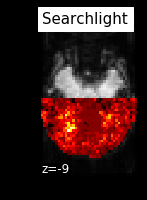

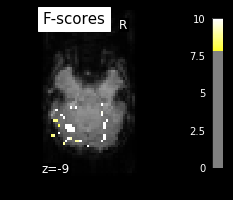

In [14]:
from nilearn import image
mean_fmri = image.mean_img(fmri_img)

from nilearn.plotting import plot_stat_map, plot_img, show
searchlight_img = new_img_like(mean_fmri, searchlight.scores_)

# Because scores are not a zero-center test statistics, we cannot use
# plot_stat_map
plot_img(searchlight_img, bg_img=mean_fmri,
         title="Searchlight", display_mode="z", cut_coords=[-9],
         vmin=.42, cmap='hot', threshold=.2, black_bg=True)

# F_score results
p_ma = np.ma.array(p_unmasked, mask=np.logical_not(process_mask))
f_score_img = new_img_like(mean_fmri, p_ma)
plot_stat_map(f_score_img, mean_fmri,
              threshold = 8,
              title="F-scores", display_mode="z",
              cut_coords=[-9],
              colorbar=True)

show()